In [1]:
import matplotlib.pyplot as plt
import seaborn as sns 
import scipy.stats as sps
import scipy.special
import scipy.integrate as integrate
from statsmodels.stats.proportion import proportion_confint
import numpy as np
import random
import math
import time
from tqdm import tqdm

## Tasks 1, 2

Функция генерации выборки с первой практики

In [2]:
def generate_n_random_numbers(N: int, distribution: str):
    """
    N - size of sample
    distribution - ["Uniform[0, 1]", "Uniform[-1, 1]", "2xUniform[-1, 1]", "3xUniform[-1, 1]", "Cauchy(0, 1)", Norm(0, 1)]
    """
    match distribution:
        case "Uniform[0, 1]":
            return [random.uniform(0, 1) for _ in range(N)]
        case "Uniform[-1, 1]":
            return [random.uniform(0, 1) * 2 - 1 for _ in range(N)]
        case "2xUniform[-1, 1]":
            t = generate_n_random_numbers(2 * N, "Uniform[-1, 1]")
            return [t[2 * i] + t[2 * i + 1] for i in range(N)]
        case "3xUniform[-1, 1]":
            t = generate_n_random_numbers(3 * N, "Uniform[-1, 1]")
            return [t[3 * i] + t[3 * i + 1] + t[3 * i + 2] for i in range(N)]
        case "Cauchy(0, 1)":
            t = generate_n_random_numbers(N, "Uniform[0, 1]")
            return list(map(lambda x: math.tan(math.pi * (x - 0.5)), t))
        case "Norm(0, 1)":
            return [random.normalvariate(0, 1) for _ in range(N)]
        case _:
            return []

In [3]:
P = 0.95
PERCENTILE = ((1 - P) / 2) * 100
norm_quantile = sps.norm(loc=0, scale=1).ppf((1 + P) / 2)
ANALYTICAL_EXPECTATION = 0
ANALYTICAL_MEDIAN = 0
ITERATIONS = 10 ** 4
BOOTSTRAP_SIZE = 1000
# NS = [10, 100, 500]
min_sample_size = 50
max_sample_size = 2000
num_of_sample_sizes = 7
BASE = 5
# NS = list(map(int, np.linspace(min_sample_size, max_sample_size, num_of_sample_sizes)))
NS = list(map(int, np.logspace(base=BASE, start=math.log(min_sample_size, BASE), stop=math.log(max_sample_size, BASE), num=num_of_sample_sizes)))
print(NS)

[50, 92, 170, 316, 584, 1081, 2000]


In [33]:
# seconds_per_quantile_for_thousand_samples = 20_334 / (sum(NS) * ITERATIONS / 1000) / 3  # has been measured once
seconds_per_quantile_for_thousand_samples = 0.15788492895411135
estimated_time = sum(NS) * ITERATIONS / 1000 * seconds_per_quantile_for_thousand_samples
print(f"Estimated time per quantile: ~{int(estimated_time // 60)}m {int(estimated_time % 60)}s (total time: ~{int(estimated_time // 60 * 3)}m {int((estimated_time * 3) % 60)}s)")

Estimated time per quantile: ~112m 58s (total time: ~336m 54s)


Функции подсчёта доверительного интервала для квантили (или медианы при $p=0,5$) точно (через формулу Бернулли) и приближённо (по локальной теореме Муавра-Лапласа)

In [4]:
def bernoulli_coef(n: int, m: int, p: float) -> float:
    return sps.binom.pmf(m, n, p)

def quantil_confidence_interval_exact(sample: list, p=0.5) -> tuple:
    sample = sorted(sample)
    n = len(sample)
    prob = (1 - P) / 2
    m_1 = -1
    cum_sum_1 = 0
    while True:
        next_coef = bernoulli_coef(n, m_1 + 1, p)
        if cum_sum_1 + next_coef > prob:
            break
        cum_sum_1 += next_coef
        m_1 += 1
    m_2 = n + 1
    cum_sum_2 = 0
    while True:
        next_coef = bernoulli_coef(n, m_2 - 1, p)
        if cum_sum_2 + next_coef > prob:
            break
        cum_sum_2 += next_coef
        m_2 -= 1
    return (sample[m_1] if m_1 >= 0 else -np.inf, sample[m_2] if m_2 <= n - 1 else np.inf)
    

In [5]:
def quantil_confidence_interval_approx(sample: list, p=0.5) -> tuple:
    sample = sorted(sample)
    n = len(sample)
    term = math.sqrt(n * p * (1 - p)) * norm_quantile
    m_1, m_2 = math.floor(n * p - term), math.ceil(n * p + term)
    return (sample[m_1] if m_1 >= 0 else -np.inf, sample[m_2] if m_2 <= n - 1 else np.inf)

Сгенерируем по $10^4$ выборок разных размеров для каждого распределения и проверим, какая доля из них будет попадать в доверительный интервал для медианы и квантилей $x_{0.01}$ и $x_{0.99}$, посчитав доверительный интервал для этой доли.

In [6]:
distros = ["Uniform[-1, 1]", "Norm(0, 1)", "2xUniform[-1, 1]"]
methods = ["exact", "approx", "ref"]
NUM_METHODS = len(methods)
methods_functions = {"exact": quantil_confidence_interval_exact, "approx": quantil_confidence_interval_approx}
sigma_squared = {"Uniform[-1, 1]": 1 / 3,
                 "Norm(0, 1)": 1,
                 "2xUniform[-1, 1]": 2 / 3}

In [7]:
print("Start generating samples...")
samples = {d: [[generate_n_random_numbers(n, d) for _ in range(ITERATIONS)]
                for n in NS] for d in tqdm(distros)}
print("Samples generated.")

Start generating samples...


100%|██████████| 3/3 [01:08<00:00, 22.92s/it]

Samples generated.


In [8]:
QUANTILES = [0.01, 0.5, 0.99]

Для того чтобы оценить, сколько доверительных интервалов на самом деле содержат реальные квантили, нужно их сначала найти для наших распределений. 

Это легко сделать для стандартных распределений $\text{Uniform}[-1, 1]$ и $\text{Norm}(0, 1)$, но несколько сложнее для $2\cdot\text{Uniform}[-1, 1]$. Для первых двух воспользуемся стандартной функцией, а для последнего напишем бинпоиск по функции распределения, поскольку она монотонна. Чтобы найти функцию распределения, проинтегрируем свёртку плотностей равномерных распределений, то есть
$$\xi, \eta \sim \text{Uniform[-1, 1]}$$
$$F_{\xi + \eta}(t) = \int_{-\infty}^t p_{\xi + \eta}(x) dx = \int_{-\infty}^t \int_{\mathbb{R}} p_\xi(y)\cdot p_\eta(x-y)dy dx$$
Внутренний интеграл легко посчитать и аналитически записать полученную функцию. Итого можем посчитать функцию распределения суммы двух равномерных распределений:

In [9]:
def sum_pdf(t: float) -> float:
    if t <= -2 or t >= 2:
        return 0
    if -2 < t <= 0:
        return (2 + t) / 4
    return (2 - t) / 4

def sum_cdf(t):
    return integrate.quad(sum_pdf, -np.inf, t)[0]

def sum_quantile(p, lo=-2, hi=2):
    val_range = [lo, hi]
    k = 0.5 * sum(val_range)
    for _ in range(32):
        val_range[int(sum_cdf(k) > p)] = k
        next_k = 0.5 * sum(val_range)
        if next_k == k:
            break
        k = next_k
    return k

Визуализируем для наглядности полученный результат

In [ ]:
QUANTILE_VALUES = {d: dict() for d in distros}
QUANTILE_VALUES["Uniform[-1, 1]"] = [sps.uniform.ppf(q, loc=-1, scale=2) for q in QUANTILES]
QUANTILE_VALUES["Norm(0, 1)"] = [sps.norm.ppf(q) for q in QUANTILES]
QUANTILE_VALUES["2xUniform[-1, 1]"] = [sum_quantile(q) for q in QUANTILES]

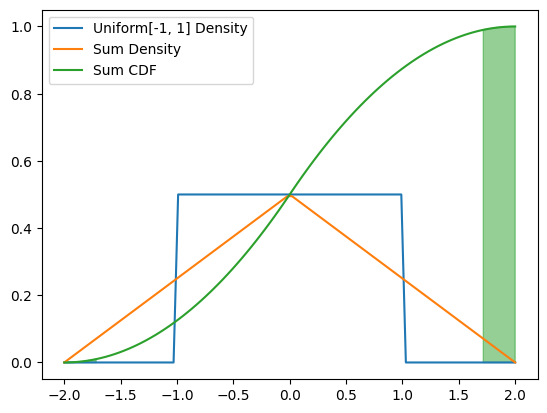

In [16]:
x = np.linspace(-2, 2, 100)
y1 = sps.uniform.pdf(x, loc=-1, scale=2)
y2 = [sum_pdf(t) for t in x]
y3 = [sum_cdf(t) for t in x]
    
plt.plot(x, y1, label='Uniform[-1, 1] Density')
plt.plot(x, y2, label='Sum Density')
plt.plot(x, y3, label='Sum CDF')
plt.fill_between(x, y3, where = (x > QUANTILE_VALUES["2xUniform[-1, 1]"][2]) | (x < QUANTILE_VALUES["2xUniform[-1, 1]"][0]), color='C2', alpha=0.5)
plt.legend()
plt.show()

In [12]:
print(QUANTILES, QUANTILE_VALUES)

[0.01, 0.5, 0.99] {'Uniform[-1, 1]': [np.float64(-0.98), np.float64(0.0), np.float64(0.98)], 'Norm(0, 1)': [np.float64(-2.3263478740408408), np.float64(0.0), np.float64(2.3263478740408408)], '2xUniform[-1, 1]': [-1.7171573103405535, -4.656612873077393e-10, 1.7171572870574892]}


Теперь приступим к подсчёту доверительных интервалов для квантилей по нашим выборкам. Для сравнения приведена реализация из библиотеки $\texttt{scipy.stats}$

In [13]:
# storing fraction of samples that are in the confidence interval for quantile and
# the confidence interval for this fraction for different methods
results = {d: {m + g: [[] for _ in range(len(QUANTILES))] for m in methods for g in ['_intervals', '_points']} for d in distros}
includes_edges = {d: np.zeros((len(methods), len(QUANTILES) - 1, len(NS))) for d in distros}
total_time = {m: 0 for m in methods}
for i, d in enumerate(distros):
    for n_id, n in enumerate(NS):
        print(f"Distribution {d}, samples size = {n}")
        for method_id, method in enumerate(methods):
            for p_id, p in enumerate(QUANTILES):
                hits_counter = 0
                includes_x_1_or_x_n = 0
                start_time = time.time()
                for sample in samples[d][n_id]:
                    sample = sorted(sample)
                    d_left, d_right = methods_functions[method](sample=sample, p=p) if method != "ref" else sps.quantile_test(sample, p=p).confidence_interval()
                    d_left = -np.inf if d_left is np.nan else d_left
                    d_right = np.inf if d_right is np.nan else d_right
                    hits_counter += d_left <= QUANTILE_VALUES[d][p_id] <= d_right
                    includes_x_1_or_x_n += d_left <= sample[0] <= d_right or d_left <= sample[len(sample) - 1] <= d_right
                    
                total_time[method] += time.time() - start_time
                results[d][method + "_intervals"][p_id].append(proportion_confint(hits_counter, ITERATIONS, alpha=1 - P, method='normal'))
                results[d][method + "_points"][p_id].append(hits_counter / ITERATIONS)
                includes_edges[d][method_id][p_id if p_id == 0 else 1][n_id] = includes_x_1_or_x_n / ITERATIONS

for method in methods:
    print(f"{method.capitalize()} method took {total_time[method]:.2f} seconds, ")

Distribution Uniform[-1, 1], samples size = 50
Distribution Uniform[-1, 1], samples size = 92
Distribution Uniform[-1, 1], samples size = 170
Distribution Uniform[-1, 1], samples size = 316
Distribution Uniform[-1, 1], samples size = 584
Distribution Uniform[-1, 1], samples size = 1081
Distribution Uniform[-1, 1], samples size = 2000
Distribution Norm(0, 1), samples size = 50
Distribution Norm(0, 1), samples size = 92
Distribution Norm(0, 1), samples size = 170
Distribution Norm(0, 1), samples size = 316
Distribution Norm(0, 1), samples size = 584
Distribution Norm(0, 1), samples size = 1081
Distribution Norm(0, 1), samples size = 2000
Distribution 2xUniform[-1, 1], samples size = 50
Distribution 2xUniform[-1, 1], samples size = 92
Distribution 2xUniform[-1, 1], samples size = 170
Distribution 2xUniform[-1, 1], samples size = 316
Distribution 2xUniform[-1, 1], samples size = 584
Distribution 2xUniform[-1, 1], samples size = 1081
Distribution 2xUniform[-1, 1], samples size = 2000
Exact 

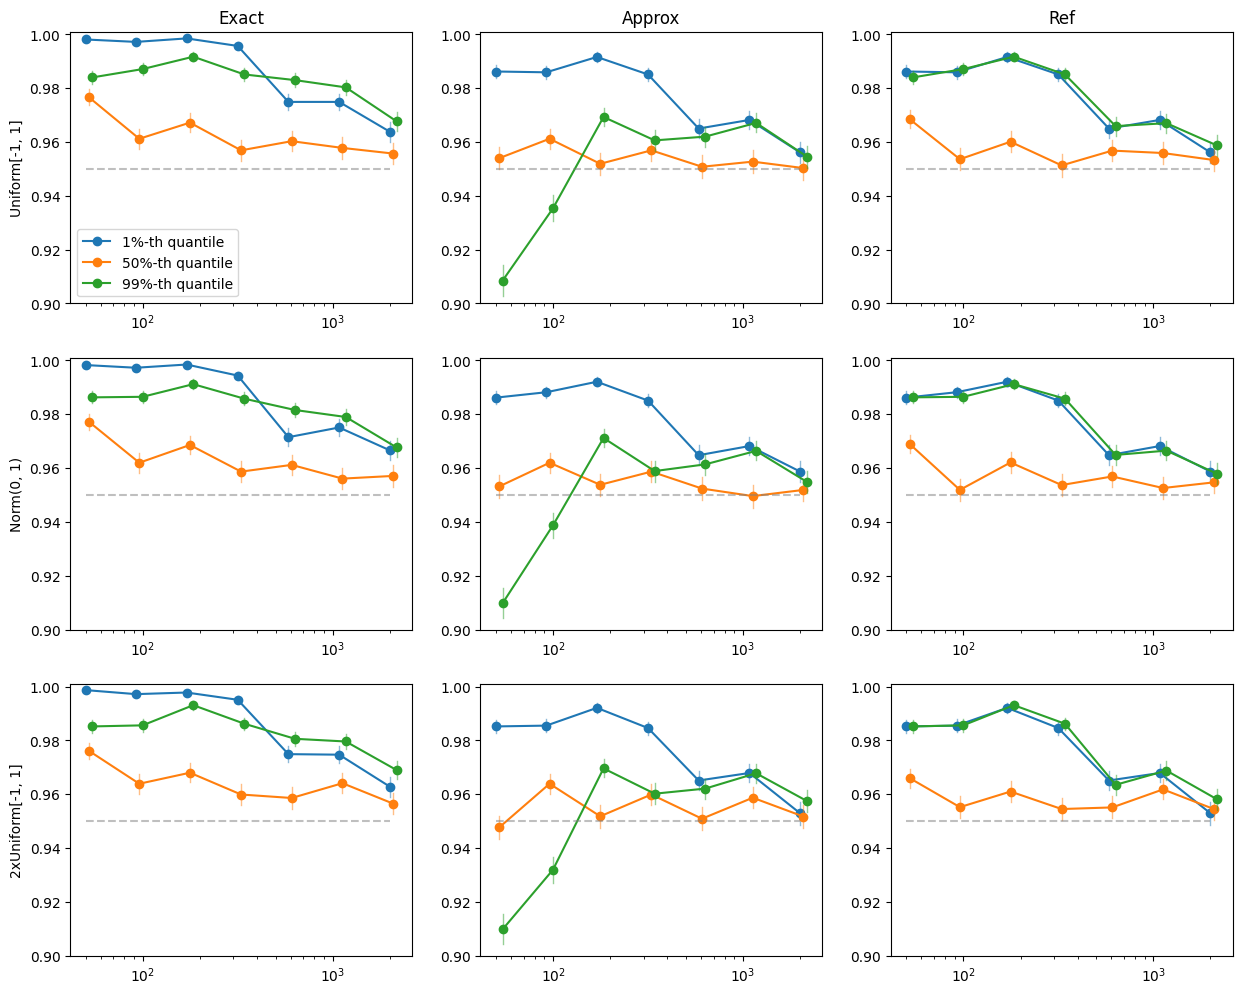

In [21]:
shift_coefficient = 1 / 40  # so that confidence intervals of different color do not overlap
_, axis = plt.subplots(3, NUM_METHODS, figsize=(5 * NUM_METHODS, 4 * len(distros)))
for i, d in enumerate(distros):
    for method_id, method in enumerate(methods):
        for p_id, p in enumerate(QUANTILES):
            for interval_id, interval in enumerate(results[d][method + "_intervals"][p_id]):
                axis[i][method_id].plot([math.pow(BASE, math.log(NS[interval_id], BASE) + p_id * shift_coefficient)] * 2, list(interval), color='C'+str(p_id), alpha=.5, linewidth=1)

            axis[i][method_id].plot([math.pow(BASE, math.log(n, BASE) + p_id * shift_coefficient) for n in NS], results[d][method + "_points"][p_id], '-o', color='C'+str(p_id), alpha=1, label=f'{int(p*100)}%-th quantile')         
        axis[i][method_id].plot(NS, [0.95] * len(NS), color='gray', alpha=.5, linestyle='--')         
        axis[i][method_id].set_xscale('log')
        axis[i][method_id].set_ylim([0.9, 1.001])
        axis[0][method_id].title.set_text(method.capitalize())
    axis[i][0].set_ylabel(d)
axis[0][0].legend()

plt.show()

И отдельно нарисуем графики для зависимости доли $X_{(1)}$ и $X_{(n)}$, попадающих в доверительные интервалы для $x_{0.01}$ и $x_{0.99}$ соответственно от размера выборки $n$.

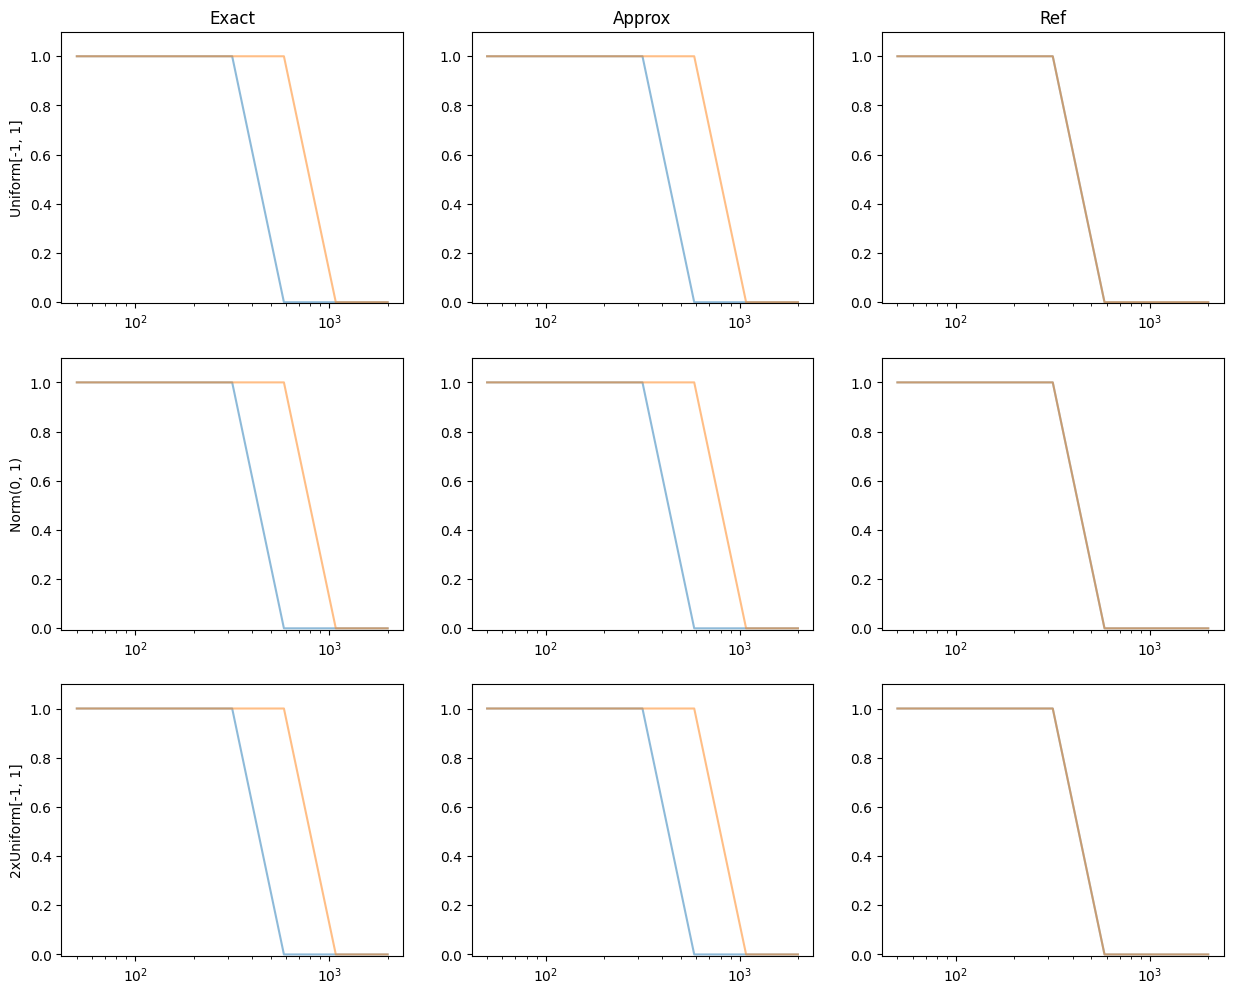

In [15]:
_, axis = plt.subplots(3, NUM_METHODS, figsize=(5 * NUM_METHODS, 4 * len(distros)))
for i, d in enumerate(distros):
    for method_id, method in enumerate(methods):
        for p_id, p in enumerate(QUANTILES):
            if p_id == 1:
                continue
            axis[i][method_id].plot(NS, includes_edges[d][method_id][p_id if p_id == 0 else 1], alpha=0.5, label=f'Fraction of samples that include x_{p}')
        axis[i][method_id].set_xscale('log')
        axis[i][method_id].set_ylim([-0.005, 1.1])
        axis[0][method_id].title.set_text(method.capitalize())
    axis[i][0].set_ylabel(d)

plt.show()